In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Download and explore the dataset

This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains five sub-directories, one per class:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

Define some parameters for the loader:

In [3]:
batch_size = 8
img_height = 120
img_width = 120

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


2022-03-18 20:29:12.332906: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-18 20:29:12.337557: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-18 20:29:12.337895: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-18 20:29:12.338703: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [6]:
class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(8, 120, 120, 3)
(8,)


In [8]:
normalization_layer = layers.Rescaling(1./255)

In [9]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 0.99803925


In [10]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [11]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile and train the model

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)

Epoch 1/15


2022-03-18 20:29:19.204718: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8201
2022-03-18 20:29:19.422958: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 32.25MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-03-18 20:29:19.430900: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 53.58MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-03-18 20:29:19.570698: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 31.82MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more mem

NotFoundError: Graph execution error:

Detected at node 'gradient_tape/sequential_1/conv2d_2/Conv2D/Conv2DBackpropFilter' defined at (most recent call last):
    File "/home/dimi/.pyenv/versions/3.9.10/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/dimi/.pyenv/versions/3.9.10/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/dimi/.pyenv/versions/3.9.10/envs/tf_env/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/home/dimi/.pyenv/versions/3.9.10/envs/tf_env/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/home/dimi/.pyenv/versions/3.9.10/envs/tf_env/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/home/dimi/.pyenv/versions/3.9.10/envs/tf_env/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/home/dimi/.pyenv/versions/3.9.10/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
      self._run_once()
    File "/home/dimi/.pyenv/versions/3.9.10/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
      handle._run()
    File "/home/dimi/.pyenv/versions/3.9.10/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/dimi/.pyenv/versions/3.9.10/envs/tf_env/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue
      await self.process_one()
    File "/home/dimi/.pyenv/versions/3.9.10/envs/tf_env/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 450, in process_one
      await dispatch(*args)
    File "/home/dimi/.pyenv/versions/3.9.10/envs/tf_env/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 357, in dispatch_shell
      await result
    File "/home/dimi/.pyenv/versions/3.9.10/envs/tf_env/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 652, in execute_request
      reply_content = await reply_content
    File "/home/dimi/.pyenv/versions/3.9.10/envs/tf_env/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/dimi/.pyenv/versions/3.9.10/envs/tf_env/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/dimi/.pyenv/versions/3.9.10/envs/tf_env/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2768, in run_cell
      result = self._run_cell(
    File "/home/dimi/.pyenv/versions/3.9.10/envs/tf_env/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2814, in _run_cell
      return runner(coro)
    File "/home/dimi/.pyenv/versions/3.9.10/envs/tf_env/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/dimi/.pyenv/versions/3.9.10/envs/tf_env/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3012, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/dimi/.pyenv/versions/3.9.10/envs/tf_env/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3191, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/dimi/.pyenv/versions/3.9.10/envs/tf_env/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3251, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_38212/3031475205.py", line 2, in <module>
      history = model.fit(
    File "/home/dimi/.pyenv/versions/3.9.10/envs/tf_env/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/dimi/.pyenv/versions/3.9.10/envs/tf_env/lib/python3.9/site-packages/keras/engine/training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/dimi/.pyenv/versions/3.9.10/envs/tf_env/lib/python3.9/site-packages/keras/engine/training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "/home/dimi/.pyenv/versions/3.9.10/envs/tf_env/lib/python3.9/site-packages/keras/engine/training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/dimi/.pyenv/versions/3.9.10/envs/tf_env/lib/python3.9/site-packages/keras/engine/training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "/home/dimi/.pyenv/versions/3.9.10/envs/tf_env/lib/python3.9/site-packages/keras/engine/training.py", line 863, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/dimi/.pyenv/versions/3.9.10/envs/tf_env/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py", line 530, in minimize
      grads_and_vars = self._compute_gradients(
    File "/home/dimi/.pyenv/versions/3.9.10/envs/tf_env/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py", line 583, in _compute_gradients
      grads_and_vars = self._get_gradients(tape, loss, var_list, grad_loss)
    File "/home/dimi/.pyenv/versions/3.9.10/envs/tf_env/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py", line 464, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/sequential_1/conv2d_2/Conv2D/Conv2DBackpropFilter'
No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine 1: UNKNOWN: CUDNN_STATUS_INTERNAL_ERROR
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4177): 'cudnnConvolutionBackwardFilter( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), output_nd_.handle(), output_data.opaque(), conv_.handle(), ToConvBackwardFilterAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, filter_.handle(), filter_data.opaque())'
  Profiling failure on CUDNN engine 2: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 36446208 bytes.
  Profiling failure on CUDNN engine 5: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4177): 'cudnnConvolutionBackwardFilter( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), output_nd_.handle(), output_data.opaque(), conv_.handle(), ToConvBackwardFilterAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, filter_.handle(), filter_data.opaque())'
  Profiling failure on CUDNN engine 0: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4177): 'cudnnConvolutionBackwardFilter( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), output_nd_.handle(), output_data.opaque(), conv_.handle(), ToConvBackwardFilterAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, filter_.handle(), filter_data.opaque())'
  Profiling failure on CUDNN engine 3: UNKNOWN: CUDNN_STATUS_INTERNAL_ERROR
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4177): 'cudnnConvolutionBackwardFilter( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), output_nd_.handle(), output_data.opaque(), conv_.handle(), ToConvBackwardFilterAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, filter_.handle(), filter_data.opaque())'
	 [[{{node gradient_tape/sequential_1/conv2d_2/Conv2D/Conv2DBackpropFilter}}]] [Op:__inference_train_function_2114]

In [ ]:
model.save_weights('model_weights/simple_classification')

In [ ]:
model.save('model/simple_classifier')

INFO:tensorflow:Assets written to: /drive/model/simple_classifier/assets


## Visualize training results

After applying data augmentation and `tf.keras.layers.Dropout`, there is less overfitting than before, and training and validation accuracy are closer aligned:

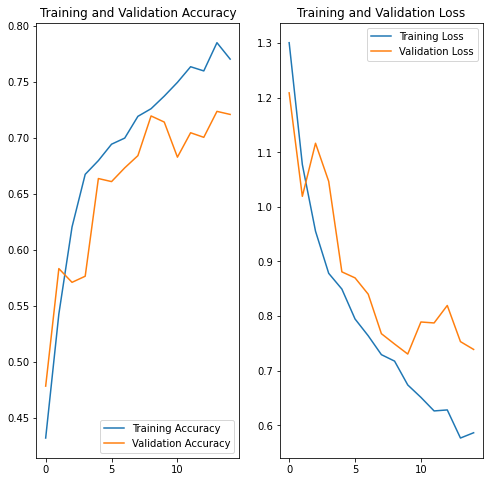

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Finally, let's use our model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and dropout layers are inactive at inference time.

In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

131072/117948 [=================================] - 0s 0us/step
This image most likely belongs to sunflowers with a 99.37 percent confidence.
